In [1]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense ,Flatten ,Conv2D ,MaxPooling2D ,Dropout ,BatchNormalization
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.callbacks import EarlyStopping ,ReduceLROnPlateau ,ModelCheckpoint
from keras.applications.mobilenet_v2 import MobileNetV2
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report

2024-05-03 00:39:02.955951: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-03 00:39:02.956213: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-03 00:39:03.113365: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Define the path to the directory containing the images
data_dir = '/kaggle/input/chinese-traffic-signs/images/'

In [3]:
# Load the CSV file into a Pandas DataFrame
df = pd.read_csv("/kaggle/input/chinese-traffic-signs/annotations.csv")
df.head()

,file_name,width,height,x1,y1,x2,y2,category
0,000_0001.png,134,128,19,7,120,117,0
1,000_0002.png,165,151,23,12,149,138,0
2,000_0003.png,128,122,22,14,116,105,0
3,000_0010.png,80,73,14,8,67,63,0
4,000_0011.png,186,174,36,15,155,157,0


# cleaning

In [4]:
print(df.columns)

Index(['file_name', 'width', 'height', 'x1', 'y1', 'x2', 'y2', 'category'], dtype='object')


In [5]:
print(df.dtypes)

file_name    object
width         int64
height        int64
x1            int64
y1            int64
x2            int64
y2            int64
category      int64
dtype: object


In [6]:
df.isnull().sum()

file_name    0
width        0
height       0
x1           0
y1           0
x2           0
y2           0
category     0
dtype: int64

In [7]:
df.duplicated().sum()

0

# exploration 

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6164 entries, 0 to 6163
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  6164 non-null   object
 1   width      6164 non-null   int64 
 2   height     6164 non-null   int64 
 3   x1         6164 non-null   int64 
 4   y1         6164 non-null   int64 
 5   x2         6164 non-null   int64 
 6   y2         6164 non-null   int64 
 7   category   6164 non-null   int64 
dtypes: int64(7), object(1)
memory usage: 385.4+ KB


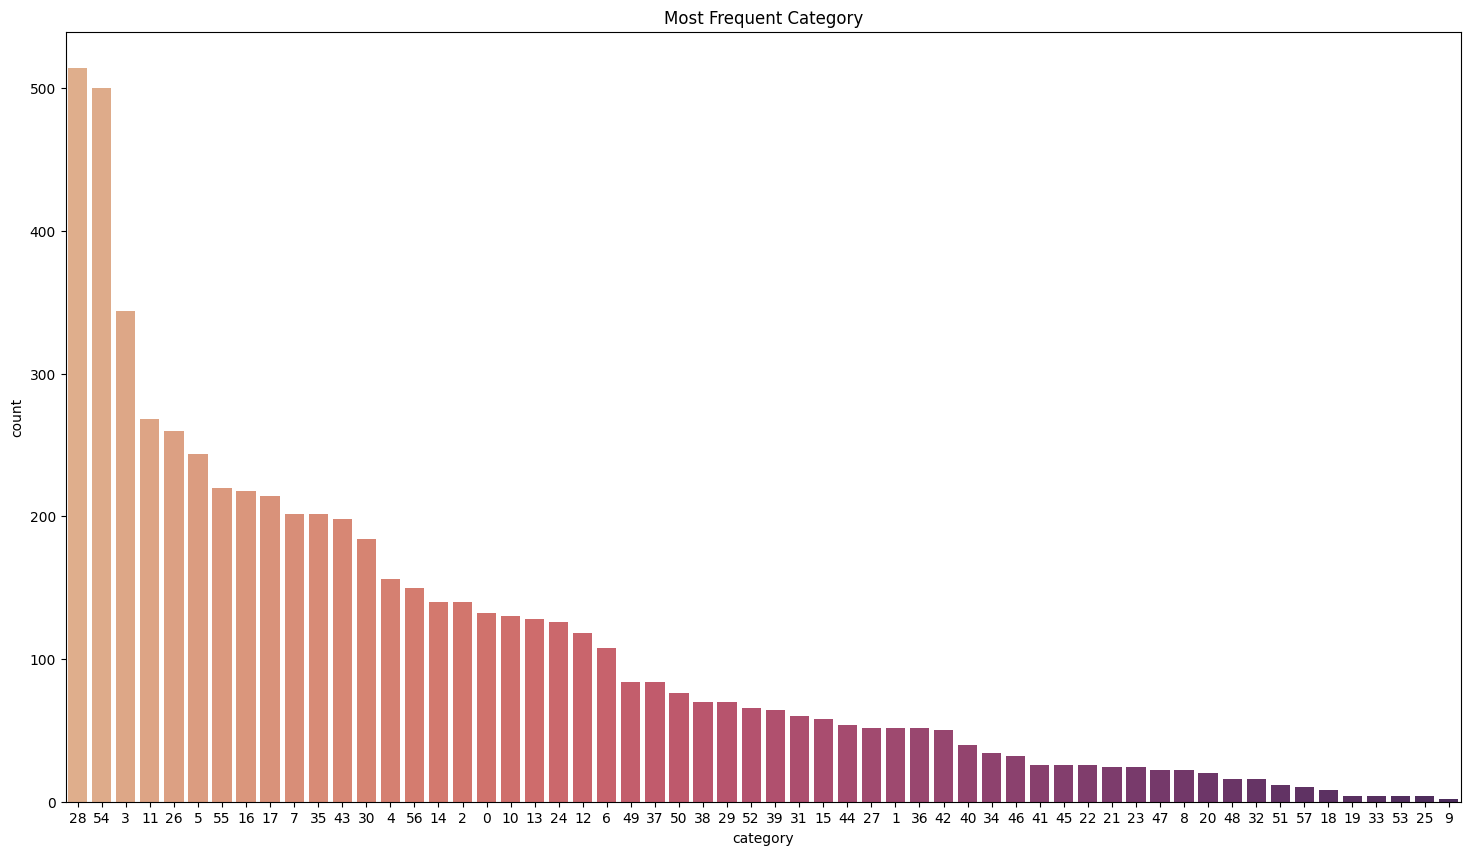

In [9]:
plt.figure(figsize=(18, 10))
sns.countplot(x='category', data=df, palette='flare', order=df['category'].value_counts().index)
plt.title('Most Frequent Category')
plt.show()

In [10]:
# Extract the file paths and labels from the DataFrame
file_paths = df['file_name'].values
labels = df['category'].values

In [11]:
# Create empty lists to store the images
images = []

In [12]:
# Loop over the file paths
for file_path in file_paths:
    # Define the path to the image file
    image_path = os.path.join(data_dir, file_path)
    # Load the image and resize it to a fixed size
    image = Image.open(image_path).resize((224, 224))
    # Append the image to the list
    images.append(np.array(image))

In [13]:
# Convert the images and labels to NumPy arrays
images = np.array(images)
labels = np.array(labels)

In [14]:
labels

array([ 0,  0,  0, ..., 56, 57, 57])

In [15]:
images[0]

array([[[131, 114,  98],
        [131, 114,  98],
        [132, 115,  98],
        ...,
        [103,  88,  77],
        [103,  88,  76],
        [103,  88,  76]],

       [[131, 114,  98],
        [131, 114,  98],
        [132, 115,  98],
        ...,
        [103,  88,  77],
        [103,  89,  76],
        [103,  89,  76]],

       [[132, 114,  99],
        [132, 114,  99],
        [131, 115,  98],
        ...,
        [102,  89,  76],
        [102,  90,  76],
        [102,  90,  76]],

       ...,

       [[154,  26,  67],
        [155,  25,  64],
        [158,  24,  60],
        ...,
        [ 91,  82,  74],
        [ 91,  83,  73],
        [ 91,  83,  73]],

       [[155,  24,  56],
        [156,  24,  57],
        [159,  25,  58],
        ...,
        [ 91,  83,  73],
        [ 92,  84,  72],
        [ 92,  84,  72]],

       [[155,  24,  51],
        [157,  24,  53],
        [160,  25,  57],
        ...,
        [ 91,  83,  73],
        [ 92,  84,  72],
        [ 92,  84,  72]]

In [16]:
# Split the data into training and testing data 
# X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.3, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(images,labels, test_size=0.2, random_state=42)

# Split the training set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [17]:
X_train[0]

array([[[116,  37,  39],
        [122,  38,  40],
        [131,  42,  44],
        ...,
        [ 72,  73,  57],
        [ 67,  68,  51],
        [ 91,  92,  73]],

       [[115,  35,  37],
        [122,  37,  40],
        [131,  42,  44],
        ...,
        [110, 112,  95],
        [108, 110,  92],
        [128, 129, 110]],

       [[113,  31,  32],
        [121,  36,  38],
        [132,  41,  44],
        ...,
        [186, 188, 170],
        [188, 191, 172],
        [200, 203, 183]],

       ...,

       [[131,  54,  61],
        [131,  54,  61],
        [131,  54,  60],
        ...,
        [ 22,  32,  19],
        [ 24,  30,  18],
        [ 25,  28,  18]],

       [[133,  56,  63],
        [133,  56,  63],
        [133,  56,  62],
        ...,
        [ 24,  33,  11],
        [ 31,  34,  15],
        [ 36,  36,  19]],

       [[133,  56,  63],
        [133,  56,  63],
        [133,  56,  62],
        ...,
        [ 25,  33,   8],
        [ 34,  37,  14],
        [ 42,  40,  20]]

In [18]:
y_train[0]

13

In [19]:
# Preprocess the data by scaling the pixel values to [0, 1] and converting the labels to one-hot encoding
X_train = X_train.astype('float32') / 255
X_val = X_val.astype('float32') / 255
X_test = X_test.astype('float32') / 255
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

In [20]:
X_train[0]

array([[[0.45490196, 0.14509805, 0.15294118],
        [0.47843137, 0.14901961, 0.15686275],
        [0.5137255 , 0.16470589, 0.17254902],
        ...,
        [0.28235295, 0.28627452, 0.22352941],
        [0.2627451 , 0.26666668, 0.2       ],
        [0.35686275, 0.36078432, 0.28627452]],

       [[0.4509804 , 0.13725491, 0.14509805],
        [0.47843137, 0.14509805, 0.15686275],
        [0.5137255 , 0.16470589, 0.17254902],
        ...,
        [0.43137255, 0.4392157 , 0.37254903],
        [0.42352942, 0.43137255, 0.36078432],
        [0.5019608 , 0.5058824 , 0.43137255]],

       [[0.44313726, 0.12156863, 0.1254902 ],
        [0.4745098 , 0.14117648, 0.14901961],
        [0.5176471 , 0.16078432, 0.17254902],
        ...,
        [0.7294118 , 0.7372549 , 0.6666667 ],
        [0.7372549 , 0.7490196 , 0.6745098 ],
        [0.78431374, 0.79607844, 0.7176471 ]],

       ...,

       [[0.5137255 , 0.21176471, 0.23921569],
        [0.5137255 , 0.21176471, 0.23921569],
        [0.5137255 , 0

In [21]:
y_train[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.])

In [22]:
print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Training set shape: (3944, 224, 224, 3) (3944, 58)
Validation set shape: (987, 224, 224, 3) (987, 58)
Test set shape: (1233, 224, 224, 3) (1233, 58)


# CNN Model

In [23]:
optimizer=Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.99)

In [24]:
model=MobileNetV2(include_top=False,input_shape=(224,224,3),weights='imagenet')

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [25]:
model.trainable=False

In [26]:
# create a new model with the pre-trained model as the first layer
Cnn_model = Sequential()
Cnn_model.add(model)

# add a flatten layer to convert the output of the pre-trained model to a 1D tensor
Cnn_model.add(Flatten())

# add a dense layer with 512 units, batch normalization
Cnn_model.add(Dense(units=512, activation='relu'))
Cnn_model.add(BatchNormalization())

# add another dense layer with 1024 units and batch normalization
Cnn_model.add(Dense(units=1024, activation='relu'))
Cnn_model.add(BatchNormalization())

# add another dense layer with 1024 units and batch normalization
Cnn_model.add(Dense(units=512, activation='relu'))
Cnn_model.add(BatchNormalization())

# add the output layer with 58 units and softmax activation
Cnn_model.add(Dense(units = 58 , activation = 'softmax'))

In [27]:
Cnn_model.compile(optimizer=optimizer,loss='categorical_crossentropy', metrics=["accuracy"])

In [28]:
history = Cnn_model.fit(X_train, y_train, epochs=10, batch_size=32 ,validation_data=(X_val, y_val))

Epoch 1/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 205s 2s/step - accuracy: 0.6584 - loss: 1.4695 - val_accuracy: 0.8906 - val_loss: 0.4183
Epoch 2/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 159s 1s/step - accuracy: 0.9630 - loss: 0.1360 - val_accuracy: 0.9645 - val_loss: 0.1338
Epoch 3/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 152s 1s/step - accuracy: 0.9753 - loss: 0.0904 - val_accuracy: 0.9250 - val_loss: 0.4090
Epoch 4/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 201s 1s/step - accuracy: 0.9614 - loss: 0.1460 - val_accuracy: 0.9615 - val_loss: 0.1438
Epoch 5/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 203s 1s/step - accuracy: 0.9826 - loss: 0.0580 - val_accuracy: 0.9564 - val_loss: 0.1899
Epoch 6/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 205s 1s/step - accuracy: 0.9872 - loss: 0.0482 - val_accuracy: 0.9473 - val_loss: 0.2549
Epoch 7/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 153s 1s/step - accuracy: 0.9850 - loss: 0.0706 - val_accuracy: 0.9787 - val_loss: 0.0909
Epoch 8/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 204s 1s/step - accuracy: 0.9916 - loss: 0.0350 - val_accu

In [29]:
Cnn_loss,Cnn_acc = Cnn_model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', Cnn_loss)
print('Test accuracy:', Cnn_acc)

Test loss: 0.24757806956768036
Test accuracy: 0.956204354763031


# training and validation accuracy

Plot the training and validation loss: Plotting the training and validation loss over epochs can help you visualize whether the model is overfitting. If the training loss continues to decrease while the validation loss starts to increase, it is a sign of overfitting.

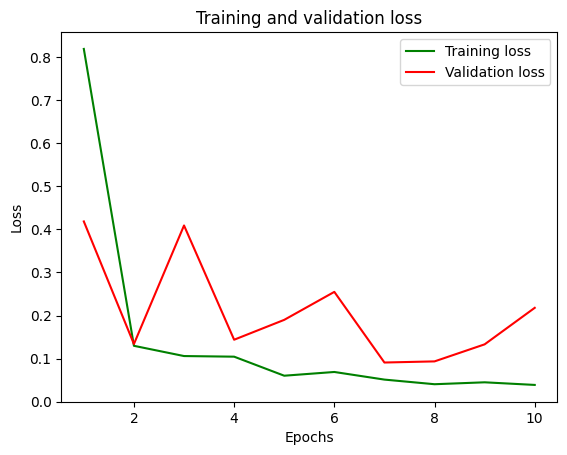

In [30]:
# Plot the training and validation loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, color='green', label='Training loss')
plt.plot(epochs, val_loss, color='red', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Plot the training and validation accuracy: Similarly, plotting the training and validation accuracy over epochs can help you identify overfitting. If the training accuracy continues to increase while the validation accuracy starts to plateau or decrease, it is a sign of overfitting.

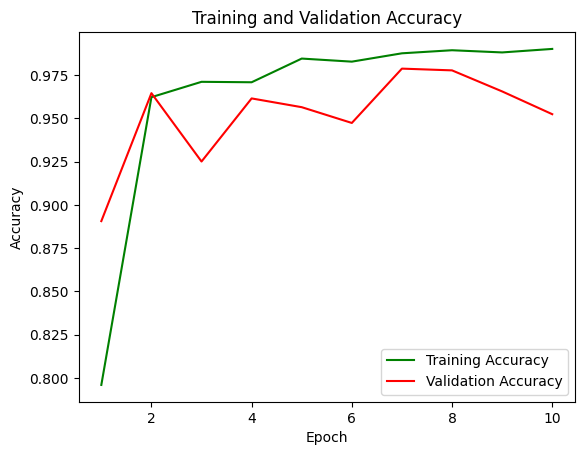

<Figure size 640x480 with 0 Axes>

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

#accuracy plot
plt.plot(epochs, acc, color='green', label='Training Accuracy')
plt.plot(epochs, val_acc, color='red', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.figure()
plt.show()

In [32]:
predictions = Cnn_model.predict(X_val)

31/31 ━━━━━━━━━━━━━━━━━━━━ 25s 759ms/step


In [33]:
predictions=np.argmax(predictions, axis=1)

In [34]:
y_val2=np.argmax(y_val, axis=1)

In [35]:
print(classification_report(y_val2, predictions))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97        20
           1       0.89      1.00      0.94         8
           2       1.00      0.91      0.95        22
           3       0.76      1.00      0.86        53
           4       0.81      1.00      0.89        25
           5       1.00      0.50      0.67        36
           6       1.00      1.00      1.00        18
           7       1.00      0.92      0.96        39
           8       0.40      1.00      0.57         2
           9       1.00      1.00      1.00         1
          10       0.85      0.85      0.85        27
          11       1.00      0.90      0.95        48
          12       1.00      1.00      1.00        16
          13       1.00      1.00      1.00        17
          14       0.87      1.00      0.93        20
          15       1.00      1.00      1.00         6
          16       1.00      1.00      1.00        37
          17       0.93    

In [36]:
cm = confusion_matrix(y_val2, predictions)

<Axes: >

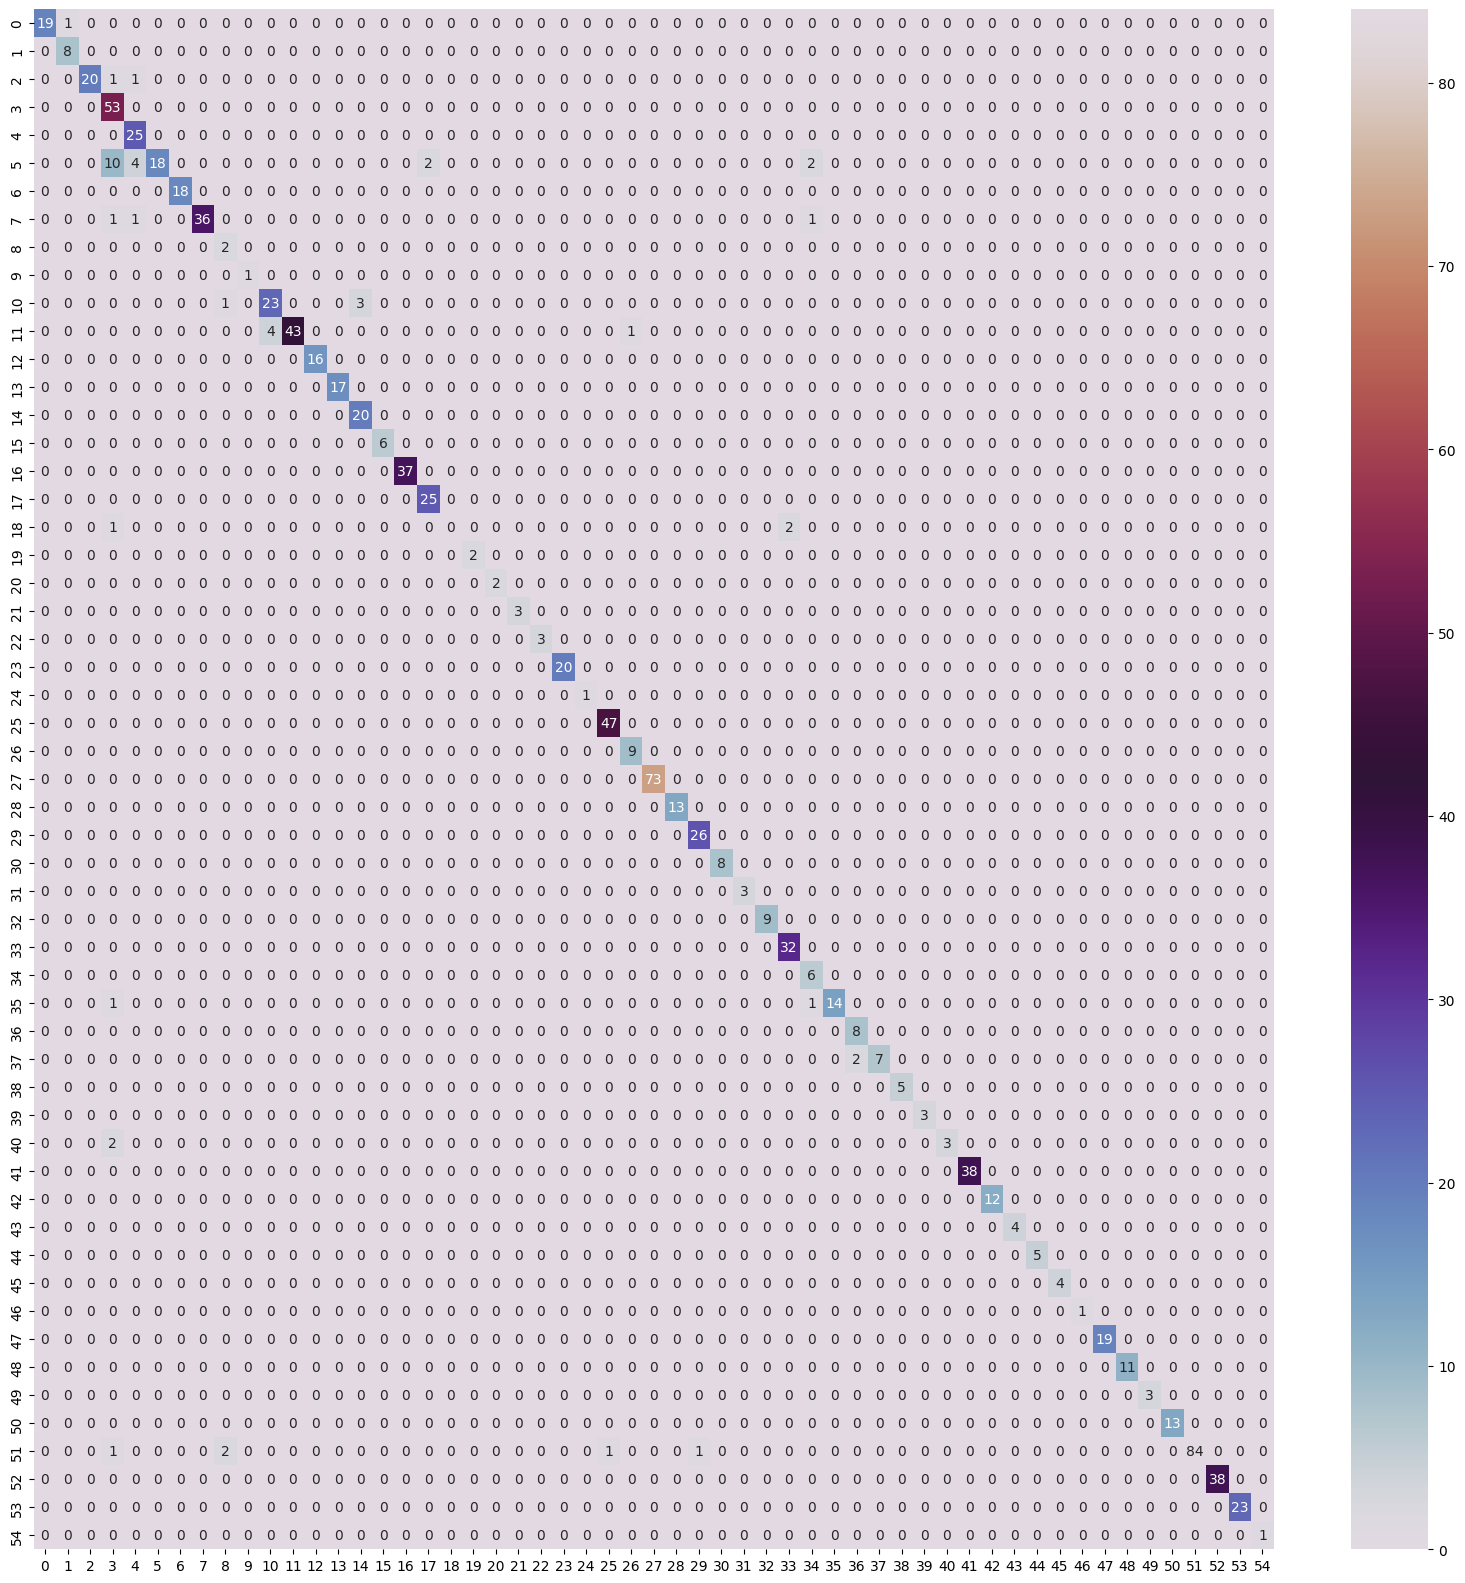

In [37]:
plt.figure(figsize=(20,20))
sns.heatmap(cm,  annot=True, fmt="d" ,cmap="twilight")

# 2nd Algorithm

In [38]:
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model

In [39]:
# Load the MobileNetV2 model without the top (fully connected) layers
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [40]:
# Freeze the base model's layers
for layer in base_model.layers:
    layer.trainable = False

In [41]:
# Add your own fully connected layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(58, activation='softmax')(x)  # Modify `num_classes` according to your task

In [42]:
# Create the 2 model
model = Model(inputs=base_model.input, outputs=predictions)

In [43]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [44]:
history2=model.fit(X_train, y_train, epochs=10, batch_size=32 ,validation_data=(X_val, y_val))

Epoch 1/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 149s 1s/step - accuracy: 0.5926 - loss: 1.7593 - val_accuracy: 0.8804 - val_loss: 0.3361
Epoch 2/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 170s 892ms/step - accuracy: 0.9314 - loss: 0.2385 - val_accuracy: 0.9534 - val_loss: 0.1596
Epoch 3/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 142s 894ms/step - accuracy: 0.9680 - loss: 0.1144 - val_accuracy: 0.9676 - val_loss: 0.1151
Epoch 4/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 143s 903ms/step - accuracy: 0.9885 - loss: 0.0386 - val_accuracy: 0.9656 - val_loss: 0.1440
Epoch 5/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 113s 908ms/step - accuracy: 0.9927 - loss: 0.0297 - val_accuracy: 0.9747 - val_loss: 0.0926
Epoch 6/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 150s 1s/step - accuracy: 0.9935 - loss: 0.0194 - val_accuracy: 0.9737 - val_loss: 0.0830
Epoch 7/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 112s 903ms/step - accuracy: 0.9936 - loss: 0.0244 - val_accuracy: 0.9645 - val_loss: 0.1585
Epoch 8/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 141s 897ms/step - accuracy: 0.9723 - loss:

In [45]:
loss,acc= model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', acc)

Test loss: 0.14220662415027618
Test accuracy: 0.9602595567703247


In [46]:
predictions = Cnn_model.predict(X_val)

31/31 ━━━━━━━━━━━━━━━━━━━━ 28s 837ms/step


In [47]:
predictions=np.argmax(predictions, axis=1)

In [48]:
y_val2=np.argmax(y_val, axis=1)

In [49]:
cm = confusion_matrix(y_val2, predictions)

<Axes: >

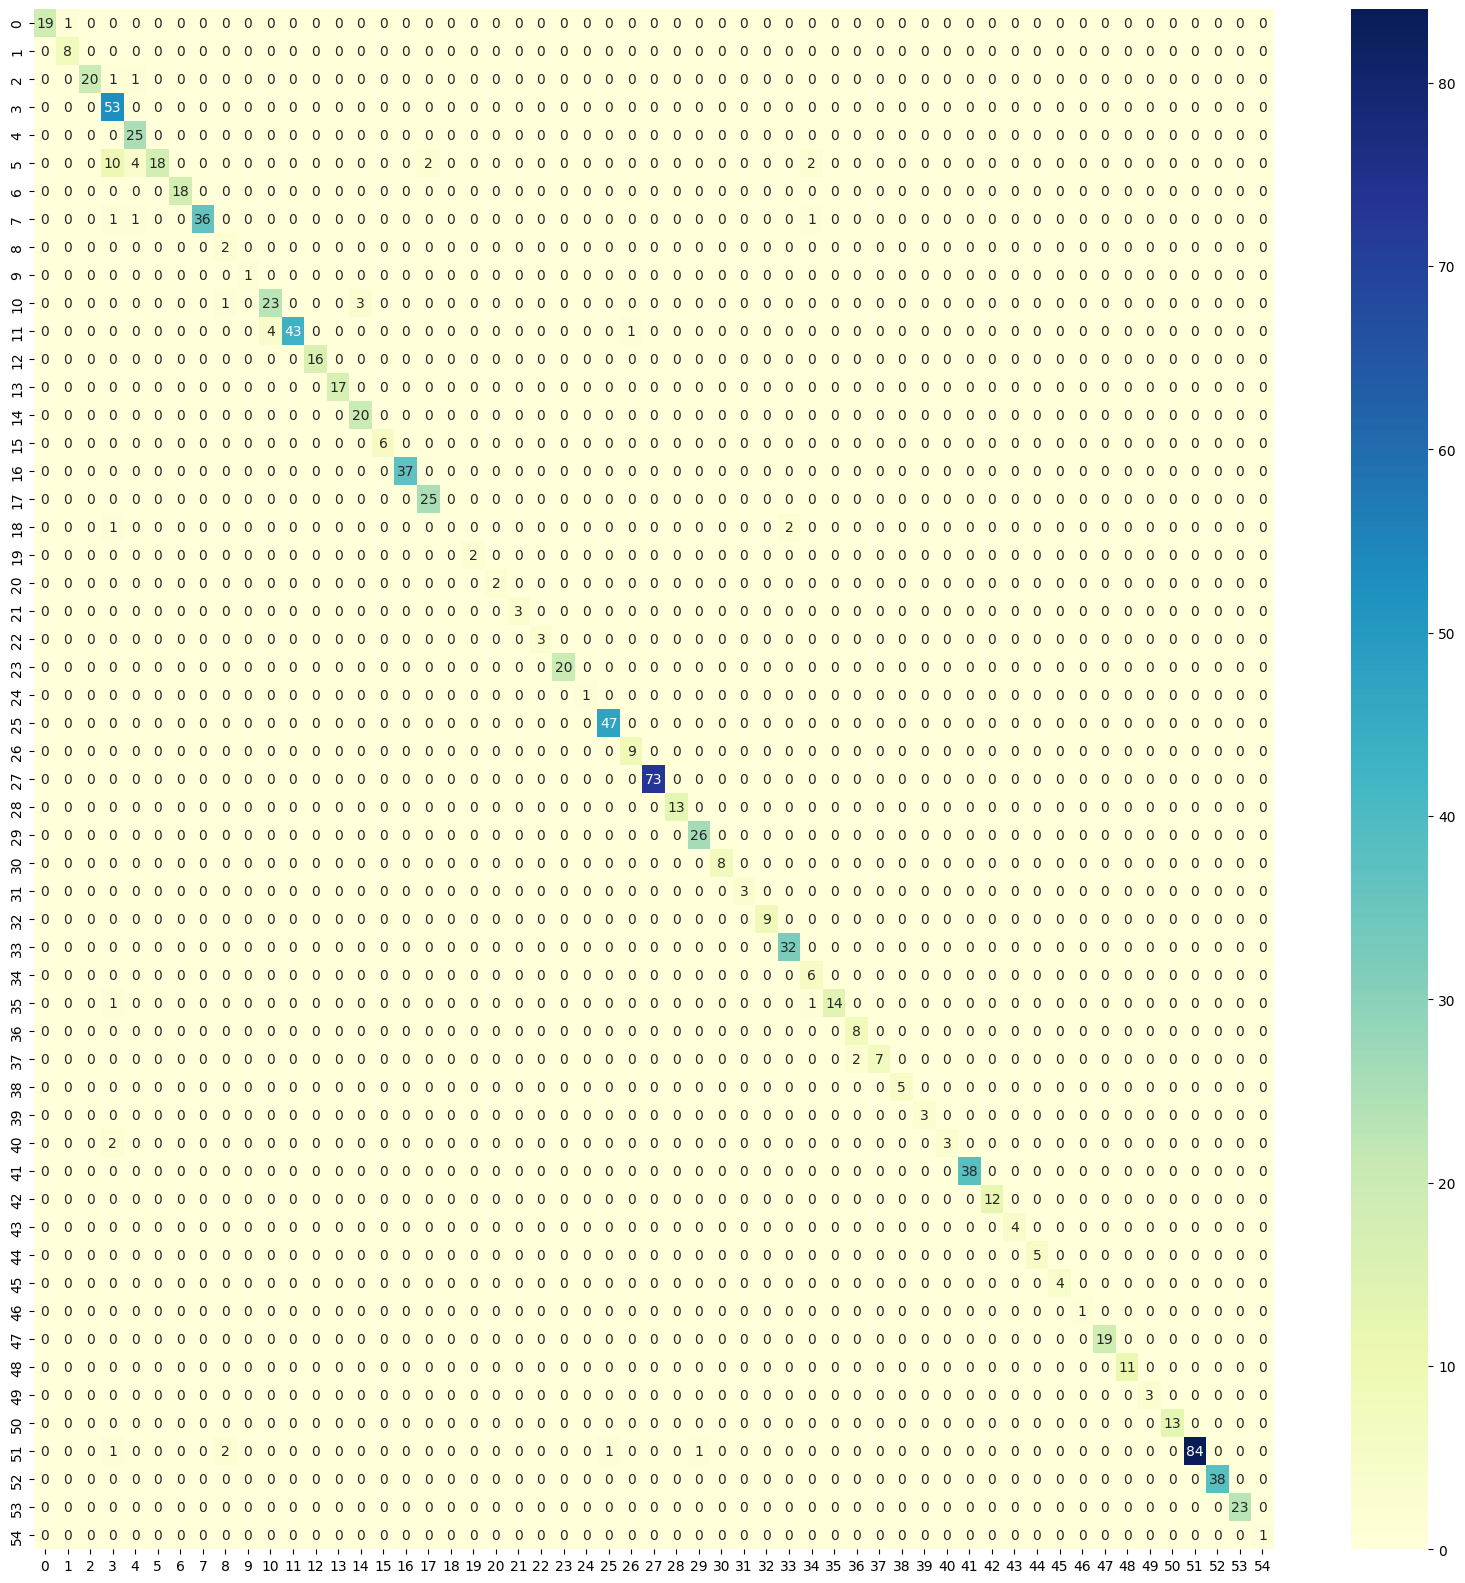

In [50]:
plt.figure(figsize=(20,20))
sns.heatmap(cm,  annot=True, fmt="d" ,cmap="YlGnBu")

# Comparison Between The Two Algorithms

In [51]:
print("1 vs 2 Performance Comparison:")
print("1 Validation Accuracy:", Cnn_acc)
print("2 Validation Accuracy:", acc)

1 vs 2 Performance Comparison:
1 Validation Accuracy: 0.956204354763031
2 Validation Accuracy: 0.9602595567703247
